# DS4440 - Practical Neural Networks
## Week 2 : Image Classification using Multi Layer Perceptron

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement

Imagine we are working with the Fashion MNIST dataset, a collection of grayscale images representing various fashion items such as shirts, shoes, and bags. By analyzing features such as pixel intensity and patterns in the images, we can uncover insights into how models process and classify visual data.
<br/>

**Our goal is to take an image as an input and predict the class of the fashion item from the dataset.**
<br/>
We will demonstrate **both**:
- **Binary classification** (classes 0 vs. 1, i.e. T-shirt vs. Trouser)
- **Multi-class classification** (all 10 classes)
<br/>
To accomplish this goal, we will use the **Multi Layer Perceptron**.

<br/>


In this notebook, we'll follow the **six** key sections below:
1. **Data Gathering**
2. **Data Wrangling**
3. **Feature Understanding & Preprocessing**
4. **Model Building**
5. **Model Validation**
6. **Results and Conclusions**

Let's dive in and explore how neural networks can tackle this exciting problem!

## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [ ]:
! pip install -r ../../requirements.txt

## 1. Data Gathering

### **About the Dataset**

The Fashion MNIST dataset consists of **70,000 labeled grayscale images**, each with a resolution of **28x28 pixels and 10 distinct classes**. This structured dataset allows us to experiment with building and training models, tuning hyperparameters, and evaluating performance.


Each training and test example is assigned to one of the following labels:

0 T-shirt/top<br/>
1 Trouser<br/>
2 Pullover<br/>
3 Dress<br/>
4 Coat<br/>
5 Sandal<br/>
6 Shirt<br/>
7 Sneaker<br/>
8 Bag<br/>
9 Ankle boot
<br/>
<br/>

**Dataset Source**
<br/>
The Fashion MNIST Dataset is a very popular dataset, which is already present in the torch library. What we're going to do is that we will fetch this dataset from torch and download it in our current working directory.
<br/><br/>

**What is the below cell doing?**<br/>
To build a model, it is very important to have a train and test split. Train split helps with training the model. And test split helps with evaluating the performance of the model. That's exactly what we've done below.

- train_dataset stores training images in a directory called as data used for training the model
- test_dataset stores testing images in a directory called as data used for evaluating the model



In [146]:
import torch
from torchvision import datasets, transforms

# Load the Fashion MNIST training and test datasets from torch
train_dataset = datasets.FashionMNIST(
    root='./data/train',  # Directory to download the dataset
    train=True,  # Load the training set
    download=True

)

test_dataset = datasets.FashionMNIST(
    root='./data/test',
    train=False,  # Load the test set
    download=True
)

### Visualize an image from the training dataset

Each image belongs to a fashion item that is given a class label.

In this instance,<br/>
**Ankle boot is represented by the class label 9.**



In [147]:
image, label = train_dataset[0]  # Access the first image and label
image, label

(<PIL.Image.Image image mode=L size=28x28>, 9)

To visualize the image, it should be converted to a numpy array so that visualization library can help display the image.

In [148]:
import numpy as np
image = np.array(image)

Display the image

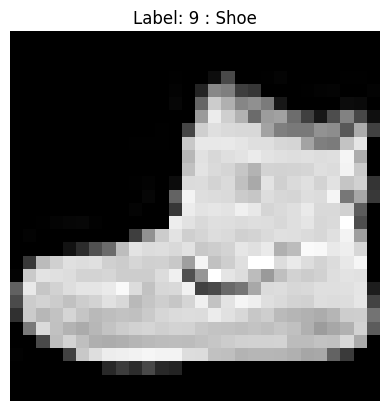

In [149]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label} : Shoe")
plt.axis('off')  # Turn off axes for clarity
plt.show()

## 2. Data Wrangling

### Check the size of the training dataset

In [150]:
num_images_train = len(train_dataset)
num_images_test = len(test_dataset)
print(f"The training dataset has {num_images_train} images")
print(f"The testing dataset has {num_images_test} images")

The training dataset has 60000 images
The testing dataset has 10000 images


### Explore the class distribution in all the fashion class labels

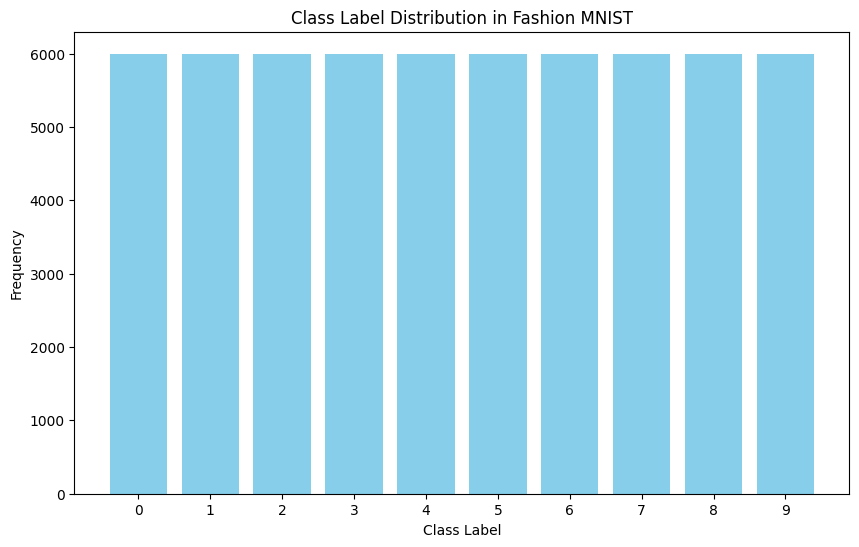

In [151]:
# Get the labels from the dataset
labels = np.array(train_dataset.targets)

# Count the occurrences of each class label (0 to 9)
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot the class distribution as a bar chart
plt.figure(figsize=(10,6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Label Distribution in Fashion MNIST')
plt.xticks(unique_labels)  # Set x-ticks to be the class labels
plt.show()

#### Insights
- There are 6000 images in each fashion item class which makes it a well distributed dataset without any class imbalance.

## 3. Feature Understanding & Preprocessing

### Model Dataset creation
The following cell converts the images in the data directory into a dataframe, where each row represents the pixel values of a 28x28 image which will be used by the MLP model. For the purposes of this notebook, lets assume you were given the dataframe. You may choose to ignore the below two cells.


In [152]:
import pandas as pd


# function to convert the fashionMNIST dataset to a dataframe
# flattens each 28x28 image into 784 columns, plus 1 column for label => 'target'.

def build_df(dataset):
    num_samples = len(dataset)
    images = np.zeros((num_samples, 28 * 28), dtype=np.uint8)  # 28x28 flattened
    labels = np.zeros(num_samples, dtype=np.uint8)

    # Populate arrays in a single loop
    for i, (img_pil, label) in enumerate(dataset):
        images[i, :] = np.array(img_pil).flatten()  # Convert and flatten image
        labels[i] = label

    # Convert to DataFrame
    df = pd.DataFrame(images)
    df['target'] = labels

    return df


In [153]:
# build DataFrames for train and test
df_train = build_df(train_dataset)
df_test = build_df(test_dataset)

print("df_train shape:", df_train.shape)  # expect (60000, 785)
print("df_test shape: ", df_test.shape)   # expect (10000, 785)

df_train.head()

df_train shape: (60000, 785)
df_test shape:  (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
# build separate DataFrames for binary and multi for train & test
# binary DF: only rows where target is 0 or 1
binary_classes = [0, 1]

# filter the training dataset
# create a boolean mask where the target column is either 0 or 1
train_mask = df_train['target'].isin(binary_classes)

# use the mask to filter the rows from the training dataset
df_train_bin = df_train[train_mask].copy()

# repeat for testing dataset
test_mask = df_test['target'].isin(binary_classes)
df_test_bin = df_test[test_mask].copy()

# multi-class DF: we keep all classes 0..9
df_train_multi = df_train.copy()
df_test_multi = df_test.copy()

print("Binary train shape:", df_train_bin.shape)
print("Binary test shape: ", df_test_bin.shape)
print("Multi-class train shape:", df_train_multi.shape)
print("Multi-class test shape: ", df_test_multi.shape)

Binary train shape: (12000, 785)
Binary test shape:  (2000, 785)
Multi-class train shape: (60000, 785)
Multi-class test shape:  (10000, 785)


In [155]:
# convert from DataFrame to X,y arrays
def df_to_numpy(df):
    # separate features from target
    X = df.drop(columns=['target']).values  # shape (N,784)
    y = df['target'].values  # shape (N,)
    return X, y

In [156]:
X_train_bin, y_train_bin = df_to_numpy(df_train_bin)
X_test_bin, y_test_bin = df_to_numpy(df_test_bin)

# multi
X_train_multi, y_train_multi = df_to_numpy(df_train_multi)
X_test_multi, y_test_multi = df_to_numpy(df_test_multi)

print("Binary train:", X_train_bin.shape, y_train_bin.shape)
print("Multi train: ", X_train_multi.shape, y_train_multi.shape)

Binary train: (12000, 784) (12000,)
Multi train:  (60000, 784) (60000,)


In [157]:
# the data passed to the model will look like this:
X_train_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [158]:
# to save the dataframe as a csv file, we can use:
#df.to_csv("Image_Dataset.csv")

## 4. Model Building

In [159]:
# function to manually create batches
def create_batches(X, y, batch_size=64, model=None):
    num_samples = len(X)
    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_X = X[start:end]
        batch_y = y[start:end]
        # convert to torch Tensors
        batch_X_t = torch.tensor(batch_X, dtype=torch.float32)
        if model=="MultiClassMLP":
            batch_y_t = torch.tensor(batch_y, dtype=torch.long)
        else:
          batch_y_t = torch.tensor(batch_y, dtype=torch.float32) # For binary classification, the target (batch_y_t) is typically expected as a torch.float32 tensor
        yield batch_X_t, batch_y_t

In [160]:
# hyperparameters
import torch.nn as nn

lr = 0.0001 # learning rate
epochs = 50
batch_size = 64
num_classes = 10  # number of classes in FashionMNIST


activation = nn.ReLU()

print('Learning rate:', lr)
print('Batch size:', batch_size)
print('Number of epochs:', epochs)
print('Activation function:', activation)

Learning rate: 0.0001
Batch size: 64
Number of epochs: 50
Activation function: ReLU()


In [161]:
# MLP architecture for binary classification
class BinaryMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out  # shape (batch_size, 1)

display(BinaryMLP(784))

BinaryMLP(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [162]:
# MLP architecture for multi-class classification
class MultiClassMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

display(MultiClassMLP(784))

MultiClassMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [163]:
# training loop
def train(model, X_train_np, y_train_np, loss_fn, optimizer, batch_size=64, epochs=5):
    model.train()
    num_samples = len(X_train_np)
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch_t, y_batch_t in create_batches(X_train_np, y_train_np, batch_size, model=model.__class__.__name__):
            outputs = model(X_batch_t)
            # for binary: shape (N,1), need .squeeze()
            loss = loss_fn(outputs.squeeze(), y_batch_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(X_batch_t)

        avg_loss = total_loss / num_samples
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


        # save the model after every epoch (useful for longer training sessions)
        torch.save(model.state_dict(), model.__class__.__name__ + '.pth') # saves it as the model class' name
        print(f"Model saved.")                                            # example: "MultiClassMLP.pth"

    # save the model again after the final epoch
    torch.save(model.state_dict(), model.__class__.__name__ + '.pth')
    print(f"Final model saved.")

In [164]:
# if we want to load a model, we can use:
# model = torch.load("model.pth"))
# model.eval()

In [165]:
# model inference
def predict(model, X, batch_size):
    model.eval()  # set the model to evaluation mode
    predictions = []

    # if X is a NumPy array, convert it to a PyTorch tensor
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)

    with torch.no_grad():  # disable gradient computation for inference
        for X_batch, _ in create_batches(X, np.zeros(len(X)), batch_size, model=model):  # Use dummy labels
            outputs = model(X_batch)  # forward pass
            predicted_classes = torch.argmax(outputs, dim=1)  # get predicted class index
            predictions.extend(predicted_classes.numpy())  # convert to NumPy and append

    return np.array(predictions)

### Binary MLP runner

In [166]:
import torch.optim as optim # torch package implementing various optimization algorithms

input_size = X_train_bin.shape[1]  # number of features in each sample
binary_mlp = BinaryMLP(input_size)       # creating an object of the MLP model class
optimizer = optim.SGD(binary_mlp.parameters(), lr=lr) # stochastic gradient descent as optimizer
loss_fn = nn.BCELoss()


train(binary_mlp, X_train_bin, y_train_bin, loss_fn, optimizer, batch_size=batch_size, epochs=epochs)

Epoch [1/50] - Loss: 4.3814
Model saved.
Epoch [2/50] - Loss: 0.1987
Model saved.
Epoch [3/50] - Loss: 0.1437
Model saved.
Epoch [4/50] - Loss: 0.1227
Model saved.
Epoch [5/50] - Loss: 0.1092
Model saved.
Epoch [6/50] - Loss: 0.0996
Model saved.
Epoch [7/50] - Loss: 0.0920
Model saved.
Epoch [8/50] - Loss: 0.0857
Model saved.
Epoch [9/50] - Loss: 0.0803
Model saved.
Epoch [10/50] - Loss: 0.0755
Model saved.
Epoch [11/50] - Loss: 0.0714
Model saved.
Epoch [12/50] - Loss: 0.0677
Model saved.
Epoch [13/50] - Loss: 0.0644
Model saved.
Epoch [14/50] - Loss: 0.0615
Model saved.
Epoch [15/50] - Loss: 0.0588
Model saved.
Epoch [16/50] - Loss: 0.0564
Model saved.
Epoch [17/50] - Loss: 0.0543
Model saved.
Epoch [18/50] - Loss: 0.0522
Model saved.
Epoch [19/50] - Loss: 0.0504
Model saved.
Epoch [20/50] - Loss: 0.0488
Model saved.
Epoch [21/50] - Loss: 0.0473
Model saved.
Epoch [22/50] - Loss: 0.0388
Model saved.
Epoch [23/50] - Loss: 0.0306
Model saved.
Epoch [24/50] - Loss: 0.0292
Model saved.
E

### Multi-class MLP runner

In [167]:
input_size = X_train_multi.shape[1]  # number of features in each sample
multi_mlp = MultiClassMLP(input_size)       # creating an object of the multi-class MLP model
optimizer = optim.SGD(multi_mlp.parameters(), lr=lr) # stochastic gradient descent as optimizer
loss_fn = nn.CrossEntropyLoss()


train(multi_mlp, X_train_multi, y_train_multi, loss_fn, optimizer, batch_size=batch_size, epochs=epochs)

Epoch [1/50] - Loss: 1.7239
Model saved.
Epoch [2/50] - Loss: 0.7178
Model saved.
Epoch [3/50] - Loss: 0.5948
Model saved.
Epoch [4/50] - Loss: 0.5389
Model saved.
Epoch [5/50] - Loss: 0.5050
Model saved.
Epoch [6/50] - Loss: 0.4812
Model saved.
Epoch [7/50] - Loss: 0.4629
Model saved.
Epoch [8/50] - Loss: 0.4483
Model saved.
Epoch [9/50] - Loss: 0.4361
Model saved.
Epoch [10/50] - Loss: 0.4257
Model saved.
Epoch [11/50] - Loss: 0.4167
Model saved.
Epoch [12/50] - Loss: 0.4087
Model saved.
Epoch [13/50] - Loss: 0.4015
Model saved.
Epoch [14/50] - Loss: 0.3949
Model saved.
Epoch [15/50] - Loss: 0.3890
Model saved.
Epoch [16/50] - Loss: 0.3835
Model saved.
Epoch [17/50] - Loss: 0.3784
Model saved.
Epoch [18/50] - Loss: 0.3738
Model saved.
Epoch [19/50] - Loss: 0.3695
Model saved.
Epoch [20/50] - Loss: 0.3653
Model saved.
Epoch [21/50] - Loss: 0.3615
Model saved.
Epoch [22/50] - Loss: 0.3578
Model saved.
Epoch [23/50] - Loss: 0.3544
Model saved.
Epoch [24/50] - Loss: 0.3511
Model saved.
E

## 5. Model Validation

In [168]:
def analyze_predictions(X_test, y_test, y_pred, task="binary"):
    df_test['true_label'] = y_test
    df_test['predicted_label'] = y_pred

    correct_preds = df_test[df_test['true_label'] == df_test['predicted_label']]
    incorrect_preds = df_test[df_test['true_label'] != df_test['predicted_label']]

    correct_examples = correct_preds.sample(n=min(3, len(correct_preds)), random_state=42)
    incorrect_examples = incorrect_preds.sample(n=min(3, len(incorrect_preds)), random_state=42)

    print(f"Task: {task}")
    print("\nCorrect Predictions:")
    print(correct_examples)

    print("\nIncorrect Predictions:")
    print(incorrect_examples)

    return df_test

In [ ]:
# running inference on test set
y_pred_bin = predict(binary_mlp, X_test_bin, batch_size)
y_pred_multi = predict(multi_mlp, X_test_multi, batch_size)


# analyze binary predictions
binary_results = analyze_predictions(X_test_bin, y_test_bin, y_pred_bin, task="binary")

# Analyze multi-class predictions
multi_results = analyze_predictions(X_test_multi, y_test_multi, y_pred_multi, task="multiclass")

## 6. Results

In [170]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch

def evaluate(model, X_test, y_test, task="binary", threshold=0.5):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        # convert test features to PyTorch tensors
        X_test_t = torch.tensor(X_test, dtype=torch.float32)

        # get model outputs
        outputs = model(X_test_t)

        if task == "binary":
            # for binary classification, apply threshold
            preds = (outputs.squeeze().numpy() >= threshold).astype(int)
        elif task == "multiclass":
            # for multi-class classification, get the class with the highest score
            preds = torch.argmax(outputs, dim=1).numpy()
        else:
            raise ValueError(f"Unsupported task type: {task}. Use 'binary' or 'multiclass'.")

    # calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    return accuracy, cm

In [171]:
# confusion Matrix for binary classification:
# [[TN, FP],
# [FN, TP]]
accuracy_bin, cm_bin = evaluate(binary_mlp, X_test_bin, y_test_bin, task="binary")
print("\nBinary Test Accuracy:", accuracy_bin)
print("Binary Confusion Matrix:")
print(cm_bin)


Binary Test Accuracy: 0.9825
Binary Confusion Matrix:
[[983  17]
 [ 18 982]]


In [172]:
# multi-Class classification
accuracy_multi, cm_multi = evaluate(multi_mlp, X_test_multi, y_test_multi, task="multiclass")
print("\nMulti-Class Test Accuracy:", accuracy_multi)
print("Multi-Class Confusion Matrix:")
display(cm_multi)


Multi-Class Test Accuracy: 0.8578
Multi-Class Confusion Matrix:


array([[812,   2,  16,  41,   8,   5, 103,   0,  12,   1],
       [  4, 963,   3,  21,   4,   0,   4,   0,   1,   0],
       [ 17,   3, 749,  13, 125,   0,  89,   0,   4,   0],
       [ 30,  14,   9, 871,  37,   1,  30,   0,   8,   0],
       [  1,   1,  88,  42, 782,   0,  80,   0,   6,   0],
       [  0,   3,   0,   0,   0, 945,   0,  26,   2,  24],
       [149,   3,  89,  34,  84,   0, 625,   0,  16,   0],
       [  0,   0,   0,   0,   0,  31,   0, 929,   1,  39],
       [  7,   0,   7,   6,   4,   6,  15,   6, 949,   0],
       [  1,   0,   0,   0,   0,   6,   0,  39,   1, 953]])